# Disseration Experiment 6d
# Generate DICE Output (Credit Default) October Twenty-Six¶
Ciaran Finnegan October 2023

# Import Libraries + Custom Functions

## Import Libraries

In [1]:
# Import libs
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
import shap
import random

# Display libraries
from IPython.display import display, HTML
from prettytable import PrettyTable

# Import necessary libraries for LIME calculations
import lime
import lime.lime_tabular

# Import necessary library for ANCHOR explainer
from alibi.explainers import AnchorTabular

# Import necessary libraries for DICE explainer
import dice_ml
from dice_ml.utils import helpers  # helper functions

import raiutils
from raiutils.exceptions import UserConfigValidationException

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


# Libraries required for metrics calculations
from scipy.spatial import distance
from sklearn.cluster import KMeans

from sklearn.preprocessing import LabelEncoder
import warnings
import sklearn.metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample


# Classifier training (not used for explainability)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

UserConfigValidationException will be deprecated from dice_ml.utils. Please import UserConfigValidationException from raiutils.exceptions.


## Custom Functions

Dataset Visualisations

In [2]:
%run ./DS_Visualisation_Functions.ipynb

Metrics

In [3]:
%run ./XAI_Metrics_Functions.ipynb

Model Evaluation Functions

In [4]:
%run ./DS_Model_Evaluation_Functions.ipynb

# Data Visualisation and Exploration

## Import Data

In [5]:
ds_file_to_load = 'credit_default_data.csv'
df = pd.read_csv(ds_file_to_load)

## Data Exploration

### Dataset Structure

In [6]:
# Display the first few rows of the dataset to understand its structure
# This function is read from the file of custom display functions
styled_dataframe(df.head())

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [7]:
# Reset default Pandas display options
pd.reset_option('display.max_columns')
pd.reset_option('display.expand_frame_repr')
pd.reset_option('display.max_colwidth')
# Display the dataframe
display(df.head())

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


### Generate Visualizations

In [8]:
# Set up the target and features to be visualised

sTarget_feature = 'default'
sFeature_analysis_1 = 'LIMIT_BAL'
sFeature_analysis_2 = 'AGE'
sFeature_analysis_3 = 'SEX'
sFeature3_ticklabel1 = 'Male'
sFeature3_ticklabel2 = 'Female'

#### Generate Visualizations to better understand the data distribution and relationships between features.

#### Bar and Box Plot Visualisations

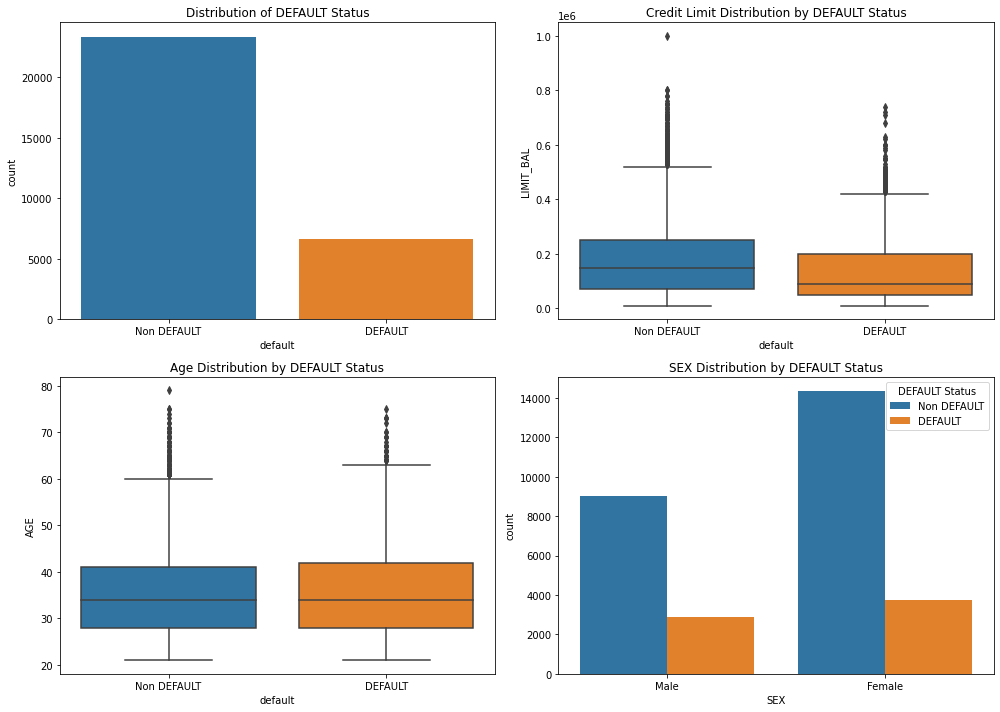

In [9]:
generate_box_plots(df, sTarget_feature, 
                       sFeature_analysis_1, 
                       sFeature_analysis_2, 
                       sFeature_analysis_3,
                       sFeature3_ticklabel1, 
                       sFeature3_ticklabel2)

#### Heatmap Visualisation

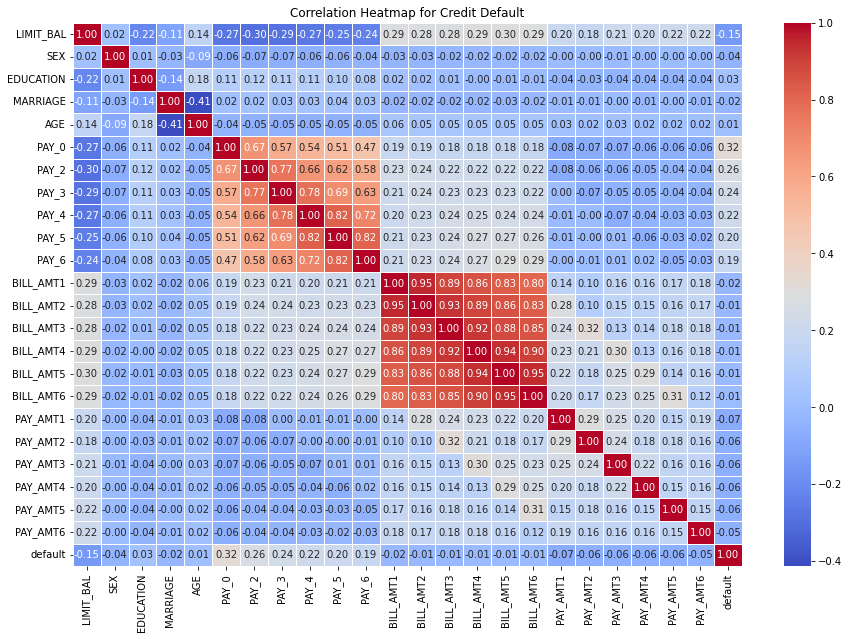

In [10]:
# Would need feature reduction to work effectively - or some other filtering
generate_heatmap(df, "Credit Default")

#### Distributions

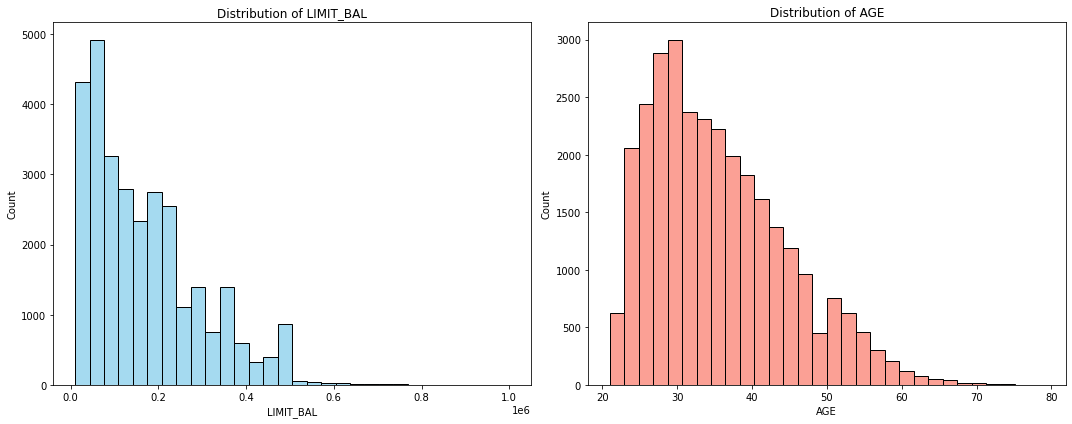

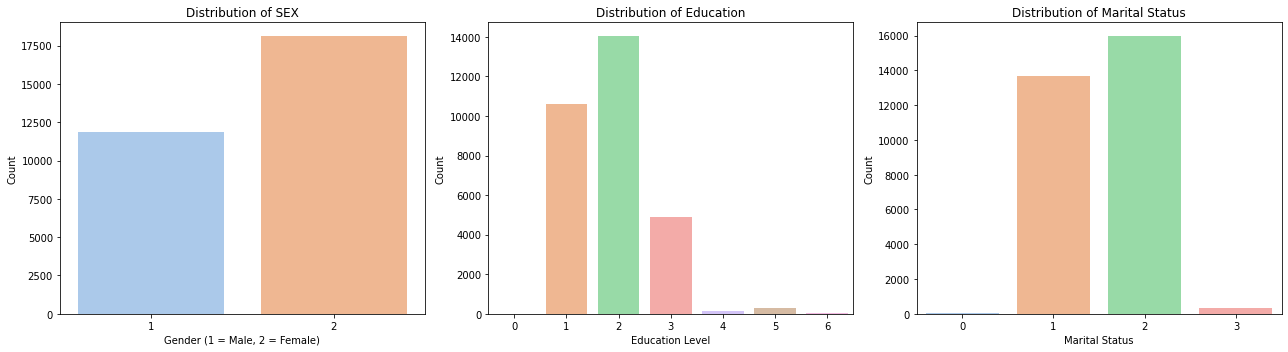

In [11]:
generate_distributions(df, 
                       sFeature_analysis_1, 
                       sFeature_analysis_2, 
                       sFeature_analysis_3)

# Feature Engineering

## Check for Missing Data

In [12]:
# Determine the threshold for missing values
threshold = 0.75 * len(df)

# Identify columns with missing values greater than the threshold
missing_columns = df.columns[df.isnull().sum() > threshold]

# Print the columns with more than 75% missing values
print("Columns with more than 75% missing values:", missing_columns)

# Drop columns with missing values greater than the threshold
df = df.drop(columns=missing_columns)

# Save or continue processing with columns removed that had high volumes of missing data


Columns with more than 75% missing values: Index([], dtype='object')


In [13]:
# Display the first few rows of the dataset to re-check structure once any columns with 
# significant amounts of missing data have been removed
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Categorical Data 

In [14]:
# List of categorical columns
cat_cols = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

In [15]:
# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, columns=cat_cols)

In [16]:
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [17]:
# Display the first few rows of the dataset to understand its structure
df_encoded.head()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8
0,20000,24,3913,3102,689,0,0,0,0,689,...,1,0,0,0,0,0,0,0,0,0
1,120000,26,2682,1725,2682,3272,3455,3261,0,1000,...,0,0,0,1,0,0,0,0,0,0
2,90000,34,29239,14027,13559,14331,14948,15549,1518,1500,...,0,0,1,0,0,0,0,0,0,0
3,50000,37,46990,48233,49291,28314,28959,29547,2000,2019,...,0,0,1,0,0,0,0,0,0,0
4,50000,57,8617,5670,35835,20940,19146,19131,2000,36681,...,0,0,1,0,0,0,0,0,0,0


In [18]:
# display all columns
pd.set_option('display.max_columns', None)
print(df_encoded)

       LIMIT_BAL  AGE  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  \
0          20000   24       3913       3102        689          0          0   
1         120000   26       2682       1725       2682       3272       3455   
2          90000   34      29239      14027      13559      14331      14948   
3          50000   37      46990      48233      49291      28314      28959   
4          50000   57       8617       5670      35835      20940      19146   
...          ...  ...        ...        ...        ...        ...        ...   
29995     220000   39     188948     192815     208365      88004      31237   
29996     150000   43       1683       1828       3502       8979       5190   
29997      30000   37       3565       3356       2758      20878      20582   
29998      80000   41      -1645      78379      76304      52774      11855   
29999      50000   46      47929      48905      49764      36535      32428   

       BILL_AMT6  PAY_AMT1  PAY_AMT2  P

# Build Model

## Downsample Majority Class

In [19]:
# Check the distribution of the target variable
target_distribution = df_encoded['default'].value_counts()

target_distribution

0    23364
1     6636
Name: default, dtype: int64

In [20]:
# Separate the majority and minority classes
df_majority = df_encoded[df_encoded['default'] == 0]
df_minority = df_encoded[df_encoded['default'] == 1]

In [21]:
# Downsample the majority class
df_majority_downsampled = resample(df_majority, 
                                   replace=False, 
                                   n_samples=target_distribution[1], 
                                   random_state=42)

In [22]:
# Combine the downsampled majority class with the minority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

In [23]:
# Shuffle the dataset to mix the data points
df_downsampled = df_downsampled.sample(frac=1, random_state=42).reset_index(drop=True)

In [24]:
# Display the distribution of the target variable in the downsampled dataset
df_downsampled['default'].value_counts()

0    6636
1    6636
Name: default, dtype: int64

## Split Features + Target

In [25]:
# Splitting the features and target variable
#X_train_downsampled = df_downsampled.drop('default', axis=1)
#y_train_downsampled = df_downsampled['default']

In [26]:
# Splitting the features and target variable
X = df_downsampled.drop('default', axis=1)
y = df_downsampled['default']

## Split Data into Test/Training Datasets

In [27]:
# Splitting the data into training and testing sets
X_train_downsampled, X_test_downsampled, y_train_downsampled, y_test_downsampled = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [28]:
# Reset Indexes
X_train_downsampled = X_train_downsampled.reset_index(drop=True)
X_test_downsampled = X_test_downsampled.reset_index(drop=True)

y_train_downsampled = y_train_downsampled.reset_index(drop=True)
y_test_downsampled = y_test_downsampled.reset_index(drop=True)

### Basic Additional Data Exploration (Training Data)

In [29]:
# Train model Stats
print("Number of Features:", X_train_downsampled.shape[1])
print("Number Continuous Features:", X_train_downsampled.shape[1] - len(cat_cols))
print("Number Categorical Features:", len(cat_cols))
print("Number Train Examples:", X_train_downsampled.shape[0])
print("Number Positive Train Examples:", (y_train_downsampled == 1).sum())
print("Number Negative Train Examples:", (y_train_downsampled == 0).sum())

Number of Features: 91
Number Continuous Features: 82
Number Categorical Features: 9
Number Train Examples: 10617
Number Positive Train Examples: 5291
Number Negative Train Examples: 5326


## Build Neural Network (w/TensorFlow/Keras)

In [30]:
# Building the ANN model using TensorFlow/Keras
model = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=(X_train_downsampled.shape[1],)),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [31]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train_downsampled, y_train_downsampled, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
266/266 [==============================] - 1s 2ms/step - loss: 2310.8010 - accuracy: 0.5308 - val_loss: 211.3440 - val_accuracy: 0.5706
Epoch 2/10
266/266 [==============================] - 0s 2ms/step - loss: 188.3069 - accuracy: 0.5500 - val_loss: 191.5451 - val_accuracy: 0.5221
Epoch 3/10
266/266 [==============================] - 0s 2ms/step - loss: 147.5839 - accuracy: 0.5406 - val_loss: 97.4605 - val_accuracy: 0.5438
Epoch 4/10
266/266 [==============================] - 0s 2ms/step - loss: 99.1839 - accuracy: 0.5527 - val_loss: 81.4427 - val_accuracy: 0.5193
Epoch 5/10
266/266 [==============================] - 0s 2ms/step - loss: 83.9135 - accuracy: 0.5415 - val_loss: 92.3637 - val_accuracy: 0.5593
Epoch 6/10
266/266 [==============================] - 0s 1ms/step - loss: 69.4777 - accuracy: 0.5482 - val_loss: 66.2475 - val_accuracy: 0.5113
Epoch 7/10
266/266 [==============================] - 0s 1ms/step - loss: 73.0481 - accuracy: 0.5447 - val_loss: 68.4385 - val_acc

# Evaluate Model

## Assess and Display Model Peformance

### Tabular Data

In [32]:
y_pred = display_model_metrics_tabular(model, X_test_downsampled, y_test_downsampled)

83/83 [==============================] - 0s 1ms/step - loss: 31.5682 - accuracy: 0.6049


83/83 [==============================] - 0s 934us/step


Metric,Value
Accuracy,0.604896
ROC AUC Score,0.632427
Precision (Class 0),0.588355
Recall (Class 0),0.663359
F1-Score (Class 0),0.623610
Precision (Class 1),0.625637
Recall (Class 1),0.547955
F1-Score (Class 1),0.584225


Tablular Done!


### Confusion Matrix

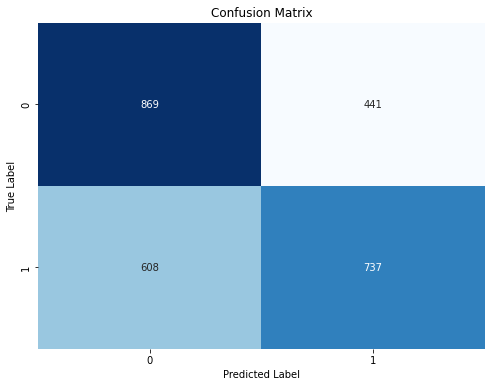

'Confusion Matrix!'

In [33]:
generate_confusion_matrix(y_test_downsampled, y_pred)

# Apply DiCE

## Generate the Counterfactuals

### Use Tensor Flow - Prepare DiCE parameters

In [34]:
# Using TensorFlow backend for DiCE
continuous_features_list = ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 
                            'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [35]:
# Using TensorFlow backend for DiCE
d = dice_ml.Data(dataframe=df_encoded, continuous_features=continuous_features_list, outcome_name='default')
m = dice_ml.Model(model=model, backend="TF2")

In [36]:
df_encoded.head()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default,SEX_1,SEX_2,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,PAY_0_-2,PAY_0_-1,PAY_0_0,PAY_0_1,PAY_0_2,PAY_0_3,PAY_0_4,PAY_0_5,PAY_0_6,PAY_0_7,PAY_0_8,PAY_2_-2,PAY_2_-1,PAY_2_0,PAY_2_1,PAY_2_2,PAY_2_3,PAY_2_4,PAY_2_5,PAY_2_6,PAY_2_7,PAY_2_8,PAY_3_-2,PAY_3_-1,PAY_3_0,PAY_3_1,PAY_3_2,PAY_3_3,PAY_3_4,PAY_3_5,PAY_3_6,PAY_3_7,PAY_3_8,PAY_4_-2,PAY_4_-1,PAY_4_0,PAY_4_1,PAY_4_2,PAY_4_3,PAY_4_4,PAY_4_5,PAY_4_6,PAY_4_7,PAY_4_8,PAY_5_-2,PAY_5_-1,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_5_6,PAY_5_7,PAY_5_8,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8
0,20000,24,3913,3102,689,0,0,0,0,689,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,120000,26,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,90000,34,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,50000,37,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,50000,57,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [37]:
df_encoded['default']

0        1
1        1
2        0
3        0
4        0
        ..
29995    0
29996    0
29997    1
29998    1
29999    1
Name: default, Length: 30000, dtype: int64

#### Generate Single Set of Counterfatuals

In [38]:
# Generate counterfactuals
exp = dice_ml.Dice(d, m)
query_instance = df_encoded.iloc[0:1].drop('default', axis=1)

In [39]:
# Generate counterfactuals
dice_exp = exp.generate_counterfactuals(query_instance, total_CFs=5, desired_class="opposite")

100%|██████████| 1/1 [00:01<00:00,  1.26s/it]


#### Visualize Counterfactuals (Single Set)

In [40]:
dice_exp.visualize_as_dataframe()

Query instance (original outcome : 0)


,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_1,SEX_2,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,PAY_0_-2,PAY_0_-1,PAY_0_0,PAY_0_1,PAY_0_2,PAY_0_3,PAY_0_4,PAY_0_5,PAY_0_6,PAY_0_7,PAY_0_8,PAY_2_-2,PAY_2_-1,PAY_2_0,PAY_2_1,PAY_2_2,PAY_2_3,PAY_2_4,PAY_2_5,PAY_2_6,PAY_2_7,PAY_2_8,PAY_3_-2,PAY_3_-1,PAY_3_0,PAY_3_1,PAY_3_2,PAY_3_3,PAY_3_4,PAY_3_5,PAY_3_6,PAY_3_7,PAY_3_8,PAY_4_-2,PAY_4_-1,PAY_4_0,PAY_4_1,PAY_4_2,PAY_4_3,PAY_4_4,PAY_4_5,PAY_4_6,PAY_4_7,PAY_4_8,PAY_5_-2,PAY_5_-1,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_5_6,PAY_5_7,PAY_5_8,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8,default
0,20000,24,3913,3102,689,0,0,0,0,689,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0



Diverse Counterfactual set (new outcome: 1.0)


,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_1,SEX_2,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,PAY_0_-2,PAY_0_-1,PAY_0_0,PAY_0_1,PAY_0_2,PAY_0_3,PAY_0_4,PAY_0_5,PAY_0_6,PAY_0_7,PAY_0_8,PAY_2_-2,PAY_2_-1,PAY_2_0,PAY_2_1,PAY_2_2,PAY_2_3,PAY_2_4,PAY_2_5,PAY_2_6,PAY_2_7,PAY_2_8,PAY_3_-2,PAY_3_-1,PAY_3_0,PAY_3_1,PAY_3_2,PAY_3_3,PAY_3_4,PAY_3_5,PAY_3_6,PAY_3_7,PAY_3_8,PAY_4_-2,PAY_4_-1,PAY_4_0,PAY_4_1,PAY_4_2,PAY_4_3,PAY_4_4,PAY_4_5,PAY_4_6,PAY_4_7,PAY_4_8,PAY_5_-2,PAY_5_-1,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_5_6,PAY_5_7,PAY_5_8,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8,default
0,20000,24,900596,3102,689,0,0,0,0,689,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
1,20000,24,3913,3102,689,0,0,0,0,742570,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
2,269933,24,3913,3102,689,0,0,0,0,689,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
3,20000,39,3913,3102,689,0,0,0,0,689,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
4,20000,79,3913,3102,689,0,0,0,0,689,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


#### Identify Counterfactual Differences (Single Set)

##### Create Display Function

In [41]:
def highlight_differences(query_instance, counterfactuals_df):
    """
    Compares a query instance (as a Series) with counterfactual instances in a DataFrame.
    
    Args:
    - query_instance (pd.Series): The original data instance.
    - counterfactuals_df (pd.DataFrame): DataFrame containing counterfactual instances.
    
    Returns:
    - A styled DataFrame where:
        * The original instance is highlighted entirely.
        * Cells with differences in counterfactuals are highlighted.
    """
    # Convert query_instance to DataFrame and concatenate with counterfactuals_df
    combined_df = pd.concat([query_instance.to_frame().T, counterfactuals_df], axis=0).reset_index(drop=True)
    
    def highlight_cells(row):
        """Helper function to apply the styling."""
        if row.name == 0:  # If it's the original instance
            return ['background-color: lightblue' for _ in row.index]
        
        # For counterfactual rows
        colors = []
        for col in row.index:
            original_value = query_instance[col]
            cf_value = row[col]
            
            # Convert to the same data type if they are different
            if type(original_value) != type(cf_value):
                try:
                    original_value = type(cf_value)(original_value)
                except ValueError:
                    try:
                        cf_value = type(original_value)(cf_value)
                    except ValueError:
                        pass
            
            # Handle float comparisons with a small tolerance
            if isinstance(original_value, float) and isinstance(cf_value, float):
                if abs(original_value - cf_value) < 1e-9:
                    colors.append('')
                else:
                    colors.append('background-color: yellow')
            elif original_value != cf_value:
                colors.append('background-color: yellow')
            else:
                colors.append('')
        return colors
    
    styled_df = combined_df.style.apply(highlight_cells, axis=1)
    return styled_df

# This refined version of the function should handle potential data type mismatches better.

##### Display Differences

In [42]:
# 2. Extract counterfactuals to a DataFrame
your_actual_counterfactuals_df = dice_exp.cf_examples_list[0].final_cfs_df

In [43]:
your_actual_counterfactuals_df.head()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_1,SEX_2,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,PAY_0_-2,PAY_0_-1,PAY_0_0,PAY_0_1,PAY_0_2,PAY_0_3,PAY_0_4,PAY_0_5,PAY_0_6,PAY_0_7,PAY_0_8,PAY_2_-2,PAY_2_-1,PAY_2_0,PAY_2_1,PAY_2_2,PAY_2_3,PAY_2_4,PAY_2_5,PAY_2_6,PAY_2_7,PAY_2_8,PAY_3_-2,PAY_3_-1,PAY_3_0,PAY_3_1,PAY_3_2,PAY_3_3,PAY_3_4,PAY_3_5,PAY_3_6,PAY_3_7,PAY_3_8,PAY_4_-2,PAY_4_-1,PAY_4_0,PAY_4_1,PAY_4_2,PAY_4_3,PAY_4_4,PAY_4_5,PAY_4_6,PAY_4_7,PAY_4_8,PAY_5_-2,PAY_5_-1,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_5_6,PAY_5_7,PAY_5_8,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8,default
0,20000,24,900596,3102,689,0,0,0,0,689,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
1,20000,24,3913,3102,689,0,0,0,0,742570,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
2,269933,24,3913,3102,689,0,0,0,0,689,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
3,20000,39,3913,3102,689,0,0,0,0,689,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
4,20000,79,3913,3102,689,0,0,0,0,689,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


In [44]:
#your_actual_counterfactuals_df = your_actual_counterfactuals_df.drop('default', axis=1)

In [45]:
#query_instance_series = df_encoded.iloc[0].drop('default')
query_instance_series = df_encoded.iloc[0]

In [46]:
styled_result = highlight_differences(query_instance_series, your_actual_counterfactuals_df)

In [47]:
# 3. Visualize differences
display(styled_result)

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default,SEX_1,SEX_2,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,PAY_0_-2,PAY_0_-1,PAY_0_0,PAY_0_1,PAY_0_2,PAY_0_3,PAY_0_4,PAY_0_5,PAY_0_6,PAY_0_7,PAY_0_8,PAY_2_-2,PAY_2_-1,PAY_2_0,PAY_2_1,PAY_2_2,PAY_2_3,PAY_2_4,PAY_2_5,PAY_2_6,PAY_2_7,PAY_2_8,PAY_3_-2,PAY_3_-1,PAY_3_0,PAY_3_1,PAY_3_2,PAY_3_3,PAY_3_4,PAY_3_5,PAY_3_6,PAY_3_7,PAY_3_8,PAY_4_-2,PAY_4_-1,PAY_4_0,PAY_4_1,PAY_4_2,PAY_4_3,PAY_4_4,PAY_4_5,PAY_4_6,PAY_4_7,PAY_4_8,PAY_5_-2,PAY_5_-1,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_5_6,PAY_5_7,PAY_5_8,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8
0,20000,24,3913,3102,689,0,0,0,0,689,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,20000,24,900596,3102,689,0,0,0,0,689,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,20000,24,3913,3102,689,0,0,0,0,742570,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,269933,24,3913,3102,689,0,0,0,0,689,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,20000,39,3913,3102,689,0,0,0,0,689,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
5,20000,79,3913,3102,689,0,0,0,0,689,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


# Generate XAI Metrics 

## Identity

### Prepare DiCE input to Identity function

In [48]:
def generate_counterfactuals_for_instances(df, num_instances=20):
    """
    Generate counterfactual explanations for a specified number of instances from a dataframe.
    
    Args:
    - df (pd.DataFrame): The dataframe containing the original instances.
    - num_instances (int): The number of instances for which to generate counterfactuals.
    
    Returns:
    - original_instances_df (pd.DataFrame): DataFrame containing the original instances.
    - counterfactuals_df (pd.DataFrame): DataFrame containing the counterfactual explanations.
    """
    # Prepare an empty dataframe for counterfactuals
    counterfactuals_list = []
    
    # Select the first 'num_instances' from the dataframe
    original_instances_df = df.head(num_instances)
    
    for _, instance in original_instances_df.iterrows():
        # Convert the instance to DataFrame
        instance_df = instance.drop('default').to_frame().T
        
        # Generate counterfactual for the instance
        dice_exp = exp.generate_counterfactuals(instance_df, total_CFs=1, desired_class="opposite")
        
        # Extract the counterfactual to a DataFrame
        cf_df = dice_exp.cf_examples_list[0].final_cfs_df.drop('default', axis=1)
        
        # Append the counterfactual to the list
        counterfactuals_list.append(cf_df.iloc[0])
    
    counterfactuals_df = pd.DataFrame(counterfactuals_list).reset_index(drop=True)
    
    return original_instances_df, counterfactuals_df

In [49]:
df_encoded

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default,SEX_1,SEX_2,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,PAY_0_-2,PAY_0_-1,PAY_0_0,PAY_0_1,PAY_0_2,PAY_0_3,PAY_0_4,PAY_0_5,PAY_0_6,PAY_0_7,PAY_0_8,PAY_2_-2,PAY_2_-1,PAY_2_0,PAY_2_1,PAY_2_2,PAY_2_3,PAY_2_4,PAY_2_5,PAY_2_6,PAY_2_7,PAY_2_8,PAY_3_-2,PAY_3_-1,PAY_3_0,PAY_3_1,PAY_3_2,PAY_3_3,PAY_3_4,PAY_3_5,PAY_3_6,PAY_3_7,PAY_3_8,PAY_4_-2,PAY_4_-1,PAY_4_0,PAY_4_1,PAY_4_2,PAY_4_3,PAY_4_4,PAY_4_5,PAY_4_6,PAY_4_7,PAY_4_8,PAY_5_-2,PAY_5_-1,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_5_6,PAY_5_7,PAY_5_8,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8
0,20000,24,3913,3102,689,0,0,0,0,689,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,120000,26,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,90000,34,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,50000,37,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,50000,57,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000,39,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
29996,150000,43,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
29997,30000,37,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
29998,80000,41,-1645,78379,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [50]:
# Execute the function for the first 20 instances of 'df_encoded'
original_df, cf_df = generate_counterfactuals_for_instances(df_encoded)

100%|██████████| 1/1 [00:01<00:00,  1.22s/it]


In [51]:
#original_df, cf_df

In [52]:
original_df

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default,SEX_1,SEX_2,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,PAY_0_-2,PAY_0_-1,PAY_0_0,PAY_0_1,PAY_0_2,PAY_0_3,PAY_0_4,PAY_0_5,PAY_0_6,PAY_0_7,PAY_0_8,PAY_2_-2,PAY_2_-1,PAY_2_0,PAY_2_1,PAY_2_2,PAY_2_3,PAY_2_4,PAY_2_5,PAY_2_6,PAY_2_7,PAY_2_8,PAY_3_-2,PAY_3_-1,PAY_3_0,PAY_3_1,PAY_3_2,PAY_3_3,PAY_3_4,PAY_3_5,PAY_3_6,PAY_3_7,PAY_3_8,PAY_4_-2,PAY_4_-1,PAY_4_0,PAY_4_1,PAY_4_2,PAY_4_3,PAY_4_4,PAY_4_5,PAY_4_6,PAY_4_7,PAY_4_8,PAY_5_-2,PAY_5_-1,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_5_6,PAY_5_7,PAY_5_8,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8
0,20000,24,3913,3102,689,0,0,0,0,689,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,120000,26,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,90000,34,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,50000,37,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,50000,57,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
5,50000,37,64400,57069,57608,19394,19619,20024,2500,1815,657,1000,1000,800,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
6,500000,29,367965,412023,445007,542653,483003,473944,55000,40000,38000,20239,13750,13770,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
7,100000,23,11876,380,601,221,-159,567,380,601,0,581,1687,1542,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
8,140000,28,11285,14096,12108,12211,11793,3719,3329,0,432,1000,1000,1000,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
9,20000,35,0,0,0,0,13007,13912,0,0,0,13007,1122,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [53]:
cf_df

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_1,SEX_2,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,PAY_0_-2,PAY_0_-1,PAY_0_0,PAY_0_1,PAY_0_2,PAY_0_3,PAY_0_4,PAY_0_5,PAY_0_6,PAY_0_7,PAY_0_8,PAY_2_-2,PAY_2_-1,PAY_2_0,PAY_2_1,PAY_2_2,PAY_2_3,PAY_2_4,PAY_2_5,PAY_2_6,PAY_2_7,PAY_2_8,PAY_3_-2,PAY_3_-1,PAY_3_0,PAY_3_1,PAY_3_2,PAY_3_3,PAY_3_4,PAY_3_5,PAY_3_6,PAY_3_7,PAY_3_8,PAY_4_-2,PAY_4_-1,PAY_4_0,PAY_4_1,PAY_4_2,PAY_4_3,PAY_4_4,PAY_4_5,PAY_4_6,PAY_4_7,PAY_4_8,PAY_5_-2,PAY_5_-1,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_5_6,PAY_5_7,PAY_5_8,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8
0,32696,24,3913,3102,689,0,0,0,0,689,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,120000,26,438386,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,90000,34,29239,14027,13559,346142,14948,15549,1518,1500,1000,1000,1000,5000,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,50000,37,46990,48233,49291,28314,28959,29547,2000,931327,1200,1100,1069,1000,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,50000,57,8617,5670,35835,392481,19146,19131,2000,36681,10000,9000,689,679,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
5,50000,37,64400,57069,57608,19394,19619,657852,2500,1815,693371,1000,1000,800,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
6,500000,29,367965,412023,445007,542653,483003,708863,55000,40000,38000,20239,13750,13770,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
7,100000,23,11876,380,601,221,-159,794246,380,601,0,581,1687,1542,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
8,140000,28,11285,14096,12108,12211,11793,3719,3329,0,432,1000,1000,488981,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
9,20000,35,0,0,0,0,13007,13912,0,0,20061,13007,1122,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


### Invoke Identity Metric Function

#### Run a Basic Test First

In [54]:
# Select two random instances from the DiCE dataframe
df_xai_numerical = cf_df

random_indices = np.random.choice(df_xai_numerical.index, size=2, replace=False)
instance_1 = df_xai_numerical.iloc[random_indices[0]]
instance_2 = df_xai_numerical.iloc[random_indices[1]]

# Compute the Euclidean distance between the selected instances - uses custom project function
distance = get_euclidean_distance(instance_1, instance_2)
print(f"Euclidean distance between instance {random_indices[0]} and instance {random_indices[1]}: {distance:.4f}")


Calculating Euclidean distance...


Euclidean distance between instance 17 and instance 16: 1626059.3591


#### Retrieve Identity Score

In [55]:
# Convert all values to float for consistent data type
original_df = original_df.astype(float)
cf_df = cf_df.astype(float)

In [56]:
from scipy.spatial import distance

In [57]:
DiCE_Identity_Metric = get_identity_metric(original_df, cf_df, "DiCE")

Instance 0:   Current matches: 1
	Closest feature instance: 9 (Distance: 23644.2441)
	Closest DiCE instance: {closest_xai_idx} (Distance: {xai_distances[closest_xai_idx]:.4f})
Instance 1:   Current matches: 1
	Closest feature instance: 7 (Distance: 22909.1983)
	Closest DiCE instance: {closest_xai_idx} (Distance: {xai_distances[closest_xai_idx]:.4f})
Instance 2:   Current matches: 1
	Closest feature instance: 7 (Distance: 37724.0862)
	Closest DiCE instance: {closest_xai_idx} (Distance: {xai_distances[closest_xai_idx]:.4f})
Instance 3:   Current matches: 1
	Closest feature instance: 5 (Distance: 26617.4049)
	Closest DiCE instance: {closest_xai_idx} (Distance: {xai_distances[closest_xai_idx]:.4f})
Instance 4:   Current matches: 1
	Closest feature instance: 16 (Distance: 54283.1463)
	Closest DiCE instance: {closest_xai_idx} (Distance: {xai_distances[closest_xai_idx]:.4f})
Instance 5:   Current matches: 1
	Closest feature instance: 3 (Distance: 26617.4049)
	Closest DiCE instance: {closest_x

#### Display Identity Score Metric

In [58]:
DiCE_Identity_Metric

25.0

In [59]:
#print(f"\nDiCE Identity Metric Score: {DiCE_Identity_Metric:.2f}%   Percentage Matches of {len(original_df)} Entries")

In [60]:
DiCE_Ident_Number = "{:.2f}%".format(DiCE_Identity_Metric)

In [61]:
display_text("DiCE Identity Metric Score: " + DiCE_Ident_Number)

## Stability

### Prepare DiCE Input for Stability Function

In [62]:
###

### Invoke Stability Metric Function

#### Retrieve Stability Score

In [63]:
DiCE_Stability_Metric = get_stability_metric_dummy(cf_df, 'DiCE')



This is the function in XAI_METRICS_FUNCTIONS -- STABILITY -- DiCE


Percentage of DiCE matches: {percentage:.2f}%   {percentage} Matches of {iOverallTotal} Entries


In [64]:
DiCE_Stability_Metric2 = get_stability_metric_y(cf_df, y_test_downsampled, 'DiCE')

Number of Instances in Cluster '0': 17
Number of Instances in Cluster '1': 3

For Class '0':
Total Instances: 8
Matching Cluster '0' Instances: 7

For Class '1':
Total Instances: 12
Matching Cluster '1' Instances: 2


This is the function in XAI_METRICS_FUNCTIONS -- STABILITY -- DiCE



Percentage of matches: 87.50%   87.5 Matches of 20 Entries


#### Display Stability Score Metric

In [65]:
DiCE_Stability_Metric

75

In [66]:
DiCE_Stbly_Number = "{:.2f}%".format(DiCE_Stability_Metric2)

In [67]:
display_text("DiCE Stability Metric Score: " + DiCE_Stbly_Number)